# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import time

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# iterate through all folders, load each image
trainAmt = 0.9
allFaces = []
labels = []

np.random.seed(42)

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("/content/drive/MyDrive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


In [4]:
print(trainFaces[0].shape)

(112, 92)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

1. Flatten Images: Convert two-dimensional images into one-dimensional arrays.

2. Center Data: Subtract mean face to standardize brightness.

3. Calculate Covariance: Analyze relationships between pixel values.

4. Compute Eigenvectors: Find directions of maximum variance.

5. Sort Eigenvectors: Based on eigenvalues, capturing most significant components.

6. Retain Top Components: Select 'numComponents' most influential eigenvectors, forming Eigenfaces.

In [5]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    # Flatten the images
    X_flattened = X.reshape(X.shape[0], -1)

    # Center the data by subtracting the mean of each feature
    mean_face = np.mean(X_flattened, axis=0)
    centered_data = X_flattened - mean_face

    # Calculate the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvectors in descending order of eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Retain only the top 'numComponents' eigenvectors
    eigenfaces = eigenvectors[:, :numComponents]

    return eigenfaces

In [6]:
# Record the start time
start_time = time.time()

components = [5,10,20,30,40,50, 100]
eigen_faces_list=[]

for pc in tqdm(components, desc='Processing Principal Components'):
    eigenfaces = principalComponentAnalysis(trainFaces, pc)
    eigen_faces_list.append(eigenfaces)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken: {elapsed_time} seconds")

Processing Principal Components: 100%|██████████| 7/7 [42:07<00:00, 361.13s/it]

Time taken: 2527.923089504242 seconds


In [7]:
output_folder = '/content/drive/MyDrive/eigen_faces_list/'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save each eigenface individually
for i, eigenface in enumerate(eigen_faces_list):
    np.save(os.path.join(output_folder, f'eigenface_{i}.npy'), eigenface)


In [ ]:
# Specify the path where eigenfaces are saved
eigenfaces_folder = '/content/drive/MyDrive/eigen_faces_list/'

# Create a list to store loaded eigenfaces
eigen_faces_list = []

# Load each eigenface individually
for i in range(7):
    eigenface_path = os.path.join(eigenfaces_folder, f'eigenface_{i}.npy')
    loaded_eigenface = np.load(eigenface_path)
    eigen_faces_list.append(loaded_eigenface)

In [8]:
print(len(eigen_faces_list ))

7


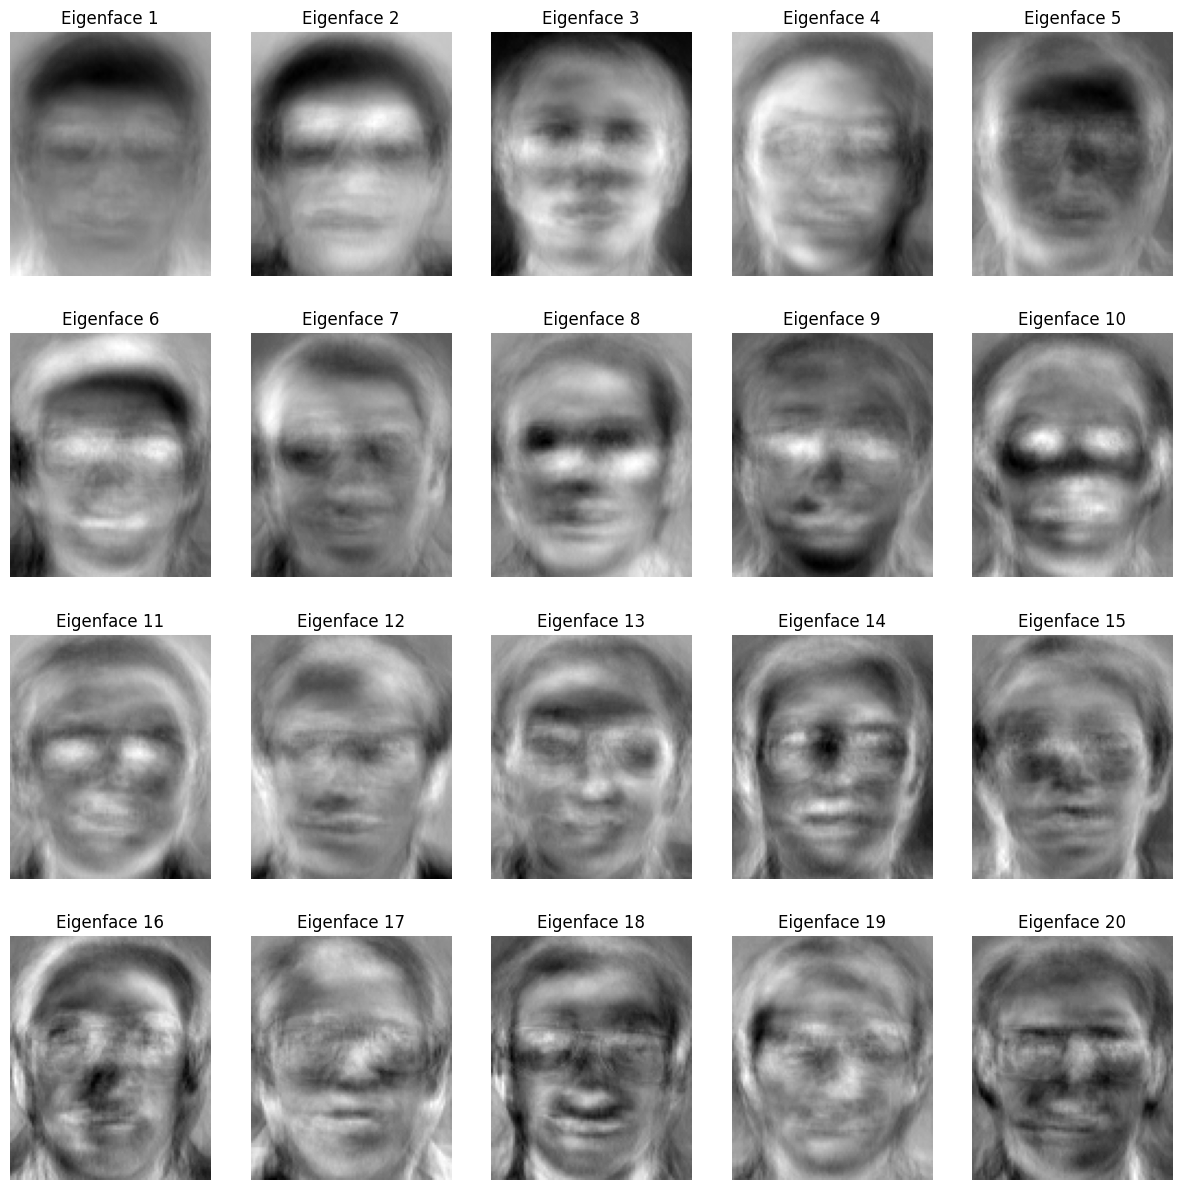

In [9]:
# plot the eigen faces
def plot_eigenfaces(eigenfaces, num_cols=5):
    """
    Plot the eigenfaces.

    Parameters:
    - eigenfaces: The eigenvectors representing the eigenfaces.
    - num_cols: Number of columns in the plot grid.

    Returns:
    - None
    """
    num_components = eigenfaces.shape[1]
    num_rows = (num_components + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 15))

    for i in range(num_components):
        plt.subplot(num_rows, num_cols, i + 1)
        eigenface = eigenfaces[:, i].reshape(trainFaces[0].shape)  # Reshape to original image dimensions
        plt.imshow(eigenface, cmap='gray')
        plt.title(f'Eigenface {i + 1}')
        plt.axis('off')

    plt.show()

# Plot the eigenfaces
plot_eigenfaces(eigen_faces_list[2])

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

1. The input test face is flattened, and the mean face is subtracted to center it.  
2. The centered test face is then projected onto the Eigenspace by calculating the weights (coefficients) using dot product with Eigenfaces.  
3. The reconstructed face is obtained by linearly combining the Eigenfaces using the calculated weights.  
4. The reconstructed face is reshaped to the original dimensions.  
5. Finally, the original and reconstructed faces are displayed side by side for comparison.  

In [10]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Reconstructs an image using Eigenfaces.

    Parameters:
    - testFace: The input test face to be reconstructed.
    - eigenFaces: The eigenvectors representing the eigenfaces.
    - meanFace: The mean face calculated during training.

    Returns:
    - reconstructedFace: The reconstructed face.
    """

    # Flatten the test face
    testFace_flattened = testFace.reshape(1, -1)

    # Center the test face by subtracting the mean face
    centered_testFace = testFace_flattened - meanFace.flatten()

    # Project the centered test face onto the Eigenspace
    weights = np.dot(centered_testFace, eigenFaces)

    # Reconstruct the face using a linear combination of Eigenfaces
    reconstructedFace_flattened = meanFace.flatten() + np.dot(weights, eigenFaces.T)

    # Reshape the reconstructed face to the original dimensions
    reconstructedFace = reconstructedFace_flattened.reshape(testFace.shape)

    return reconstructedFace

In [20]:
test_face_index = 5  # Choose the index of a test face to reconstruct
test_face = testFaces[test_face_index]

# Reconstruct the test face using Eigenfaces
reconstructed_face = imageReconstruction(test_face, eigen_faces_list[2], np.mean(trainFaces, axis=0))

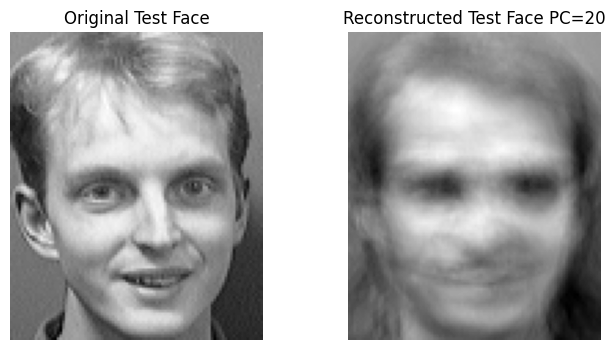

In [22]:
# plot recontructions here
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_face, cmap='gray')
plt.title('Original Test Face')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face, cmap='gray')
plt.title('Reconstructed Test Face PC=20')
plt.axis('off')

plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

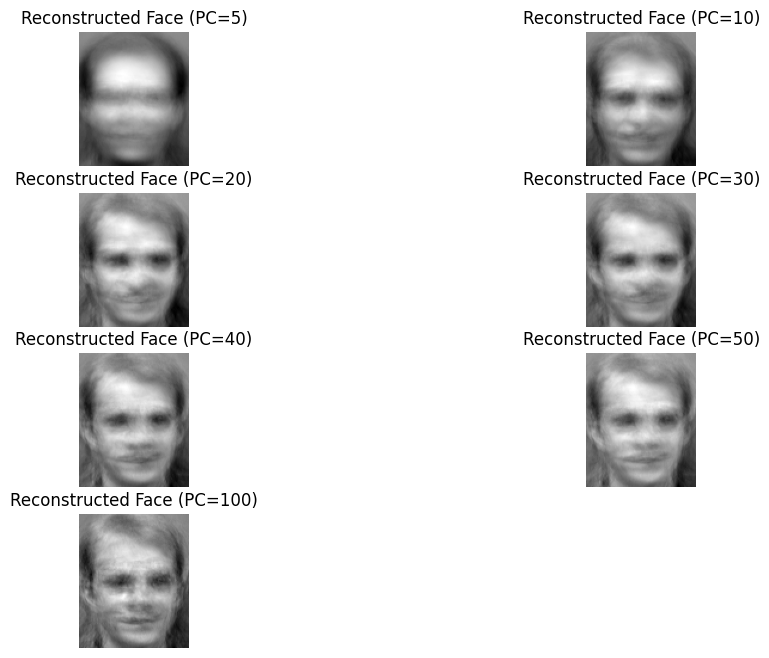

In [19]:
test_face_index = 5  # Choose the index of a test face to reconstruct
test_face = testFaces[test_face_index]
def displayNfactors():
    num_components = len(components)
    rows = int(np.ceil(num_components / 2))
    cols = 2

    plt.figure(figsize=(12, 8))

    for i, (eigenfaces, pc) in enumerate(zip(eigen_faces_list, components), 1):
        # Reconstruct the test face using Eigenfaces
        reconstructed_face = imageReconstruction(test_face, eigenfaces, np.mean(trainFaces, axis=0))

        plt.subplot(rows, cols, i)
        plt.imshow(reconstructed_face, cmap='gray')
        plt.title(f'Reconstructed Face (PC={pc})')
        plt.axis('off')

    plt.show()

displayNfactors()

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

1. Preprocess Test Image: Flatten and center the test image using the mean face from training.

2. Projection onto Eigenspace: Project the centered image onto the eigenspace defined by eigenfaces.

3. Reconstruction: Reconstruct the test image by combining eigenfaces with calculated weights.

4. Closest Match: Identify the closest match in the training set based on reconstruction error.

5. Results: Return information about the closest match, including the image, error value, and predicted class label.

In [23]:
def getClass(test_image, eigenfaces, mean_face, X_train, y_train):
    """
    Face recognition based on the norm.

    Parameters:
    - test_image: The test image to classify.
    - eigenfaces: The eigenvectors representing the eigenfaces.
    - mean_face: The mean face calculated during training.
    - X_train: Training set images.
    - y_train: Training set labels.

    Returns:
    - result: A dictionary containing the following information:
        - 'image_with_smallest_error': The image from the training set with the smallest reconstruction error.
        - 'error_value': The reconstruction error for the closest match.
        - 'prediction_class': The predicted class label for the test image.
    """

    # Flatten the test image
    test_image_flattened = test_image.flatten()

    # Center the test image by subtracting the mean face
    centered_test_image = test_image_flattened - mean_face.flatten()

    # Project the centered test image onto the eigenspace
    weights = np.dot(centered_test_image, eigenfaces)

    # Reconstruct the test image using a linear combination of eigenfaces
    reconstructed_image_flattened = mean_face.flatten() + np.dot(weights, eigenfaces.T)

    # Reshape the reconstructed image to the original dimensions
    reconstructed_image = reconstructed_image_flattened.reshape(test_image.shape)

    # Find the closest match in the training set
    errors = np.linalg.norm(X_train.reshape(X_train.shape[0], -1) - reconstructed_image_flattened, axis=1)
    closest_match_index = np.argmin(errors)

    result = {
        'image_with_smallest_error': X_train[closest_match_index],
        'error_value': errors[closest_match_index],
        'prediction_class': y_train[closest_match_index]
    }

    return result

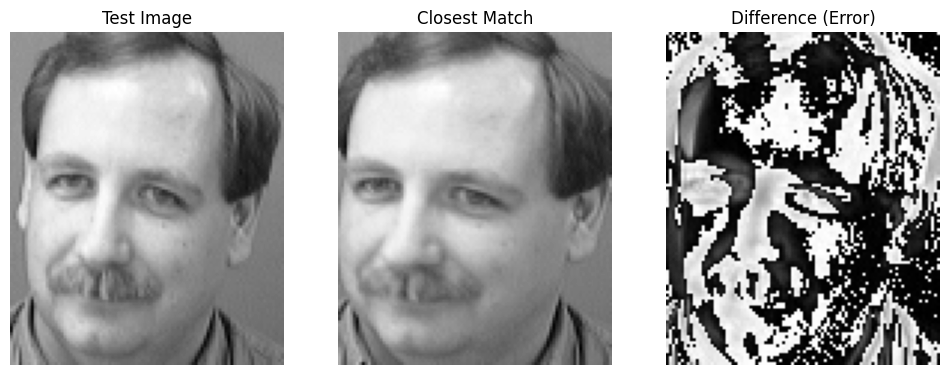

Error Value: 2342.026995562169
Prediction Class: 25
Actual Class: 25
Overall Mean Squared Error: 2294.2300397878194


In [24]:
# Create an empty list to store recognition results for all test images
recognition_results = []
error_values = []
eigenfaces = eigen_faces_list[5]

# Iterate through all test images
for test_image in testFaces:
    # Run the face recognition module for each test image
    recognition_result = getClass(test_image, eigenfaces, np.mean(trainFaces, axis=0), trainFaces, trainLabels)
    recognition_results.append(recognition_result)
    error_values.append(recognition_result['error_value'])

# Display results for the first test image (you can extend this for all images)
first_test_image_index = 0
first_test_image = testFaces[first_test_image_index]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(first_test_image, cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recognition_results[first_test_image_index]['image_with_smallest_error'], cmap='gray')
plt.title('Closest Match')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recognition_results[first_test_image_index]['image_with_smallest_error'] - first_test_image, cmap='gray')
plt.title('Difference (Error)')
plt.axis('off')

plt.show()

print(f"Error Value: {recognition_results[first_test_image_index]['error_value']}")
print(f"Prediction Class: {recognition_results[first_test_image_index]['prediction_class']}")
print(f"Actual Class: {testLabels[first_test_image_index]}")

# Calculate the Mean Squared Error for the overall test dataset
mse_overall = np.sum(error_values) / len(testFaces)

print(f"Overall Mean Squared Error: {mse_overall}")

In [25]:
print(len(testFaces))

40


Iterate through all the images in the test data and test the accuracy by taking different number of components

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
components = [5, 10, 20, 30, 40, 50, 100]
mse = []
accuracy_list = []

for i in tqdm(range(len(components)), desc='Processing Components'):
    # Compute eigenfaces using the specified number of components
    eigenfaces = eigen_faces_list[i]

    # Create an empty list to store recognition results for all test images
    error_values = []
    predicted_labels = []

    # Iterate through all test images
    for test_image in tqdm(testFaces, desc=f'Processing Test Images for {components[i]} Components', leave=False):
        # Run the face recognition module for each test image
        recognition_result = getClass(test_image, eigenfaces, np.mean(trainFaces, axis=0), trainFaces, trainLabels)
        error_values.append(recognition_result['error_value'])
        predicted_labels.append(recognition_result['prediction_class'])

    # Calculate the Mean Squared Error for the overall test dataset
    mse_overall = np.sum(error_values) / len(testFaces)
    mse.append(mse_overall)

    # Calculate accuracy
    true_labels = testLabels
    accuracy = accuracy_score(true_labels, predicted_labels)
    accuracy_list.append(accuracy)

Processing Components: 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]


Plot Number of eigenvectors vs Mean Square Error

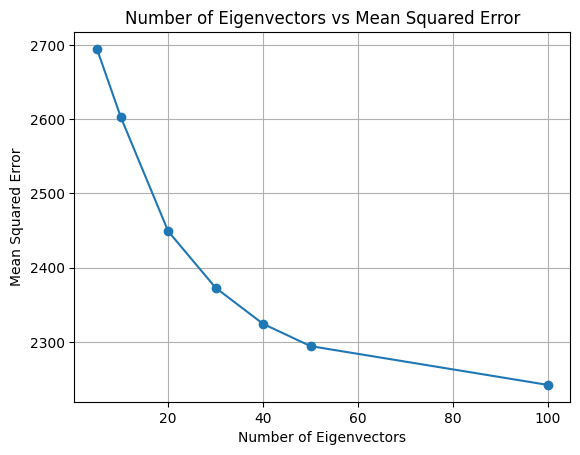

In [28]:
# Plot the Number of eigenvectors vs Mean Square Error
plt.plot(components, mse, marker='o')
plt.title('Number of Eigenvectors vs Mean Squared Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

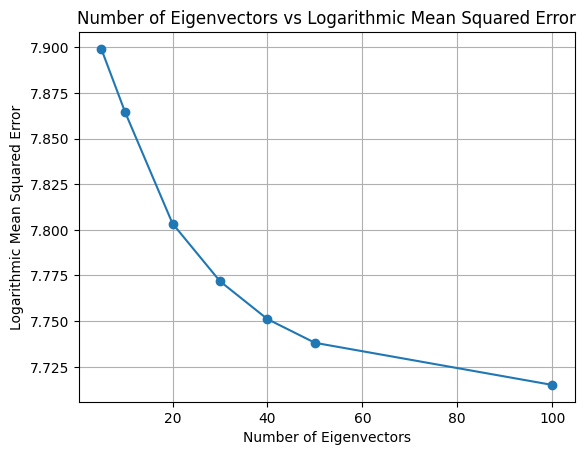

In [29]:
# Plot the Number of eigenvectors vs Logarithmic Mean Square Error
plt.plot(components, np.log(mse), marker='o')
plt.title('Number of Eigenvectors vs Logarithmic Mean Squared Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Logarithmic Mean Squared Error')
plt.grid(True)
plt.show()

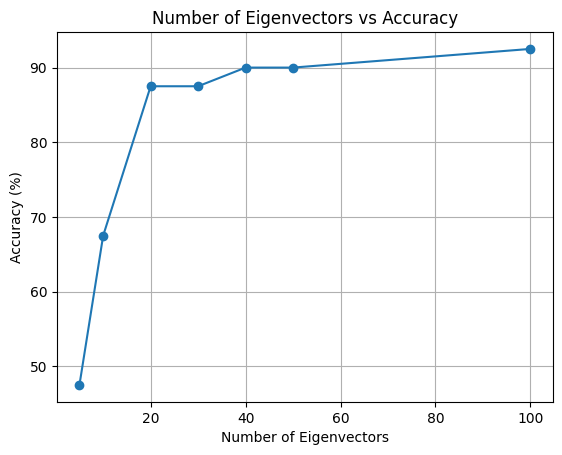

In [30]:
# Convert accuracy values to percentages
accuracy_percentage = [acc * 100 for acc in accuracy_list]

# Plot the Number of eigenvectors vs Accuracy in percentage
plt.plot(components, accuracy_percentage, marker='o')
plt.title('Number of Eigenvectors vs Accuracy')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
